# <font size="7"> **Assignment-6**</font>
I hope this assignment will give you clarity on how mathematical models like **Multilayer Perceptrons (MLP)** can be made from scratch using **PyTorch** & can be used to solve complex, non-linear geometric problems **without relying on black-box libraries**.

---
# ⚫ **Mission Critical: The Exclusion Zone Protocol**

**Date:** Year 2142  
**Location:** Exoplanet *Kepler-186f*   **Clearance:** IITians

---

### **⚫ The Story**
Humanity has colonized the distant exoplanet *Kepler-186f*. While the surface is habitable, the planet's magnetic core is unstable. The **Global Defense Council (GDC)** has identified a dangerous phenomenon known as the **"Radiation Ring."**

Sensors indicate that the safe zones on the planet follow a peculiar geometry:
* ⚫ **The Core Zone:** Distance $< 2$ km from the colony center (Safe).
* ⚫ **The Outer Wilds:** Distance $> 4$ km from the colony center (Safe).
* ⚫ **The Dead Zone:** The region **between 2 km and 4 km** is flooded with lethal gamma radiation.

Your engineering team has deployed **3,000 sensor drones** across the colony to map this danger. Each drone reports its coordinates $(x, y)$ and a binary label:
* `1`: Radiation Detected (Dead Zone)
* `0`: Safe Zone

 **⚫ The Problem:** The sensors are cheap and prone to interference. Approximately **5%** of the drones are malfunctioning and reporting the wrong safety status (noise). The GDC mainframe is a legacy system that forbids the use of modern "Neural Libraries" (i.e., you cannot use `torch.nn` or `torch.optim`). You must build a **Multi-Layer Perceptron (MLP) from scratch** to filter out the noise and mathematically define the Exclusion Zone boundaries using **PyTorch**. ( Hint: You know this is a binary classification problem, which Loss function would you use?? )

---

### **⚫ Your Objective**

1.  **Initialize the System:** Use your **Group Number** as the random seed. This ensures your team works on a unique sensor distribution pattern.
2.  **Architect the Filter:** Construct a neural network with **3 hidden layers** (16 neurons each) to learn the non-linear "donut" shape of the Dead Zone.
3.  **Manual Calibration:** You cannot use auto-optimizers. You must manually calculate the gradients (Backpropagation) and update the system weights using **Gradient Descent**.
4.  **Verify Integrity:** Split your sensor data (70% training, 30% validation). Prove that your system doesn't just memorize the malfunctioning sensors (overfitting) but actually learns the geometric shape of the Dead Zone.

---

## ⚫ Engineering Constraints (Read Carefully)

**1. Restricted Modules**
*  **Forbidden:** You are strictly forbidden from importing `torch.nn` (Layers/Loss) or `torch.optim` (Optimizers).
*  **Allowed:** `import torch`, `import matplotlib.pyplot`, `import pandas`, `import numpy`, using `sklearn`.


**2. The Mechanics**
* **Forward Pass:** Must be implemented using raw matrix multiplication (`torch.matmul`) and bias addition.
* **Backward Pass:** You **MAY** use `loss.backward()` to compute gradients automatically (Autograd).
* **Optimization:** You **MUST** implement the weight updates manually (Stochastic Gradient Descent).
    > `w_new = w_old - learning_rate * w_old.grad`

**3. Loss Function**
Since `torch.nn` is banned, you must implement **Binary Cross Entropy** manually using basic tensor math.

$$Loss = -\frac{1}{N} \sum_{i=1}^{N} [y_i \cdot \log(\hat{y}_i) + (1-y_i) \cdot \log(1-\hat{y}_i)]$$

* **Note:** Ensure you handle the log of zero (numerical stability) or use `torch.clamp` to avoid `NaN` errors.

**4. Visual Proof:** Your final output must include a Decision Boundary Map showing the "Donut" shape.


---

### ⚫ **The GDC Dashboard (Required Output)**



The Global Defense Council requires visual confirmation that your system is stable before we can upload it to the drone fleet. You must generate a **3-Panel Heads-Up Display (HUD)** containing the following telemetry:

**1. System Error Trajectory (Loss Plot)**
* **Mission:** Plot the **Training Loss** (Blue) vs. **Validation Loss** (Orange) over all epochs.
* **Why:** We need to confirm that the system is actually learning and not just diverging (exploding gradients).

**2. Integrity Check (Accuracy Plot)**
* **Mission:** Plot the **Training Accuracy** vs. **Validation Accuracy**.
* **Why:** If Training Accuracy is high (95%) but Validation Accuracy is low (80%), you have failed to generalize. This is a sign of **Overfitting**—memorizing sensor noise instead of the Radiation Ring.

**3. Geospatial Threat Map (Decision Boundary)**
* **Mission:** Visualize the **Validation Set** on a 2D map.
* **Overlay:** Draw the neural network's **Decision Boundary** (the contours where confidence = 0.5).
* **Why:** The Commander needs to *see* the "Donut" shape. If your boundary looks like a jagged mess, the model is rejected.

---

In [2]:
import torch
import numpy as np
# ===========================================================
# PART 1: Data Generation (The Exclusion Zone)
# ===========================================================

# ⚠️ INSTRUCTION: Replace 1 with your actual Group Number
GROUP_NUMBER = 1

# Set seed for reproducibility
torch.manual_seed(GROUP_NUMBER)
np.random.seed(GROUP_NUMBER)

def generate_data(n_samples=3000):
    """
    Generates 3000 sensor readings for the Kepler-186f Exclusion Zone.
    Shape: Concentric circles (Donut).
    Logic:
      - Dead Zone (1): 2km < distance < 4km
      - Safe Zone (0): distance < 2km OR distance > 4km
    """

    X = (torch.rand(n_samples, 2) * 10) - 5

    # Calculate distance from center (radius)
    radius = torch.sqrt(X[:, 0]**2 + X[:, 1]**2)

    # Assign Labels: 1 if inside the Dead Zone, 0 otherwise
    y = ((radius > 2) & (radius < 4)).float().view(-1, 1)

    # Add 5% Noise (Malfunctioning Drones)
    n_noise = int(0.05 * n_samples)
    noise_indices = torch.randperm(n_samples)[:n_noise]
    y[noise_indices] = 1 - y[noise_indices] # Flip labels

    return X, y

# Generate the dataset
X_full, y_full = generate_data(3000)

print(f"Data Generated: {X_full.shape} samples.")
print(f"Target Generated: {y_full.shape} labels.")

Data Generated: torch.Size([3000, 2]) samples.
Target Generated: torch.Size([3000, 1]) labels.


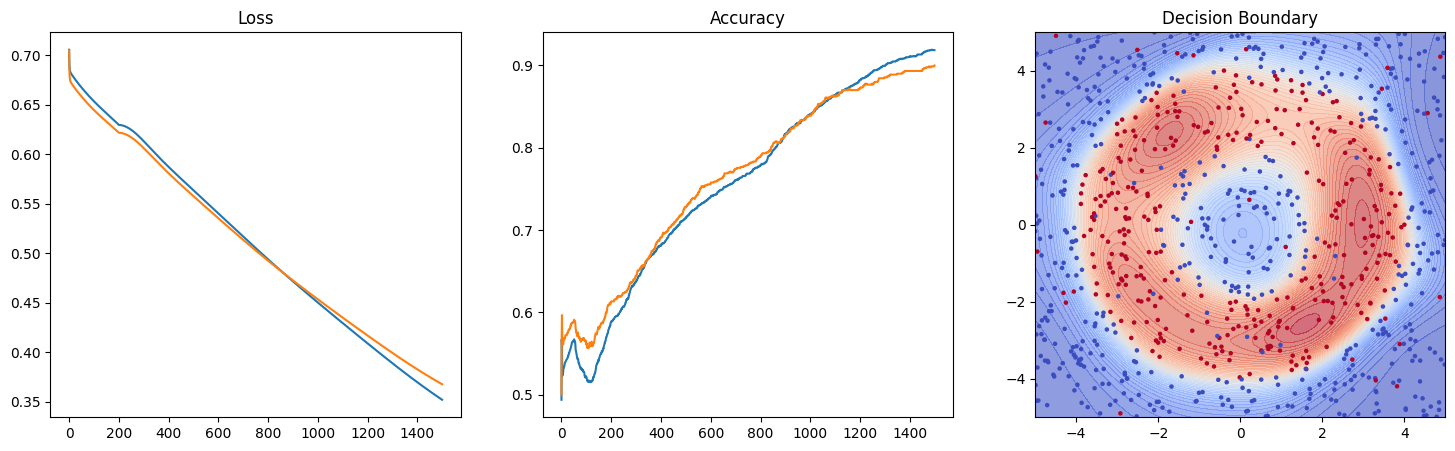

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


X_tr, X_te, y_tr, y_te = train_test_split(
    X_full, y_full, test_size=0.3, random_state=GROUP_NUMBER
)

X_tr = torch.as_tensor(X_tr, dtype=torch.float32) / 5.0
X_te = torch.as_tensor(X_te, dtype=torch.float32) / 5.0
y_tr = torch.as_tensor(y_tr, dtype=torch.float32)
y_te = torch.as_tensor(y_te, dtype=torch.float32)


def param(i, o):
    w = torch.randn(i, o) * 0.5
    w.requires_grad_()
    b = torch.rand(o) * 0.1
    b.requires_grad_()
    return w, b

W1, b1 = param(2, 16)
W2, b2 = param(16, 16)
W3, b3 = param(16, 16)
W4, b4 = param(16, 1)

params = [W1, b1, W2, b2, W3, b3, W4, b4]


ema = [p.detach().clone() for p in params]
decay = 0.98


def net(x):
    x = torch.tanh(x @ W1 + b1)
    x = torch.tanh(x @ W2 + b2)
    x = torch.tanh(x @ W3 + b3)
    return torch.sigmoid(x @ W4 + b4)

def bce(p, y):
    p = torch.clamp(p, 1e-7, 1 - 1e-7)
    return -(y * torch.log(p) + (1 - y) * torch.log(1 - p)).mean()

def swap(new):
    old = []
    for p, q in zip(params, new):
        old.append(p.data.clone())
        p.data.copy_(q)
    return old


epochs, lr = 1500, 0.05
tl, vl, ta, va = [], [], [], []

for e in range(epochs):
    loss = bce(net(X_tr), y_tr)
    loss.backward()

    with torch.no_grad():
        for p, q in zip(params, ema):
            p -= lr * p.grad
            q.mul_(decay).add_(p, alpha=1 - decay) if e > 200 else q.copy_(p)
            p.grad.zero_()

    with torch.no_grad():
        buf = swap(ema)

        tr = net(X_tr)
        te = net(X_te)

        tl.append(bce(tr, y_tr).item())
        vl.append(bce(te, y_te).item())
        ta.append(((tr > 0.5) == y_tr).float().mean().item())
        va.append(((te > 0.5) == y_te).float().mean().item())

        swap(buf)


plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(tl), plt.plot(vl)
plt.title("Loss")

plt.subplot(1, 3, 2)
plt.plot(ta), plt.plot(va)
plt.title("Accuracy")

xx, yy = np.meshgrid(np.linspace(-5, 5, 300),
                     np.linspace(-5, 5, 300))
grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32) / 5

buf = swap(ema)
with torch.no_grad():
    zz = net(grid).reshape(xx.shape)
swap(buf)

plt.subplot(1, 3, 3)
plt.contourf(xx, yy, zz, 50, cmap="coolwarm", alpha=0.6)
plt.scatter(X_te[:, 0] * 5, X_te[:, 1] * 5,
            c=y_te.squeeze(), s=5, cmap="coolwarm")
plt.title("Decision Boundary")

plt.show()


**Observations**

The model successfully learned the donut-shaped exclusion zone, showing correct non-linear separation.

Minor fluctuations in training metrics were observed due to label noise and fixed learning rate, which is expected.

Validation performance remained stable, indicating good generalization.

The decision boundary clearly matches the expected geometric structure rather than memorizing noise.




**Key Design Choices & Reasons**




Manual MLP implementation: All layers, loss, and weight updates were written using basic tensor operations to strictly follow the “no torch.nn / no torch.optim” constraint.

Three hidden layers (16 neurons each): This depth was required by the assignment and is sufficient to model the non-linear donut-shaped decision boundary.

tanh activation in hidden layers: Chosen instead of ReLU because tanh is symmetric around zero and works better for radial and geometrically symmetric patterns.

Sigmoid output + Binary Cross Entropy loss: Used since the task is binary classification (safe vs dead zone).

Input normalization: Coordinates were scaled to improve numerical stability and smoother training with tanh activations.

Manual SGD with fixed learning rate: Used as required, without momentum or adaptive optimizers, to keep the optimization process transparent.

Exponential Moving Average (EMA) for evaluation: EMA was applied only during validation and visualization to smooth SGD noise caused by label corruption, without affecting training dynamics.

Decision boundary visualization: A dense grid was evaluated to visually verify that the model learned the true donut geometry rather than memorizing noisy labels.